In [53]:
import urllib.request
import bs4 as bs
import re
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import LinearSegmentedColormap 
import seaborn as sns; sns.set()
import matplotlib.image as mpimg
from matplotlib.pyplot import show 

In [54]:
colnames = ['Booking Time',
           'Booking Status',
           'Booking Reference Number',
           'Booked for User Name',
           'Booked for User Org Unit',
           'Booked for User Email Address',
           'Use Type',
           'Purpose of Booking']
df = pd.DataFrame(columns=colnames)
df_secondary = pd.DataFrame(columns=['Top position','Booking Date'])

In [55]:
rootdir = 'Connexion'
date_list = []
source_code = []
for subdir, dirs, files in os.walk(rootdir):
    for file in files:
        HtmlFile = open(os.path.join(subdir, file), 'r', encoding='utf-8')
        source_code.append(HtmlFile.read())
        date_list.append(file.strip('.html').split('_'))

In [56]:
booking_title = re.compile('.*Booking Time.*')
for date, daily_booking in zip(date_list,source_code):
    soup = bs.BeautifulSoup(daily_booking)
    div_tags = soup.find_all('div',{'class':"scheduler_bluewhite_event scheduler_bluewhite_event_line0","title":booking_title})
    booking_list = [[item.split(':',1)[1].strip() for item in booking.get('title').split('\n')]for booking in div_tags]
    facility_list = [[item.split(':',1)[1].strip(),date[0]+'/'+date[1]+'/2020'] for booking in div_tags  for item in booking.get('style').split(';') if item.split(':',1)[0].strip() == 'top' ]
    df = df.append(pd.DataFrame(booking_list,columns = colnames))
    df_secondary = df_secondary.append(pd.DataFrame(facility_list,columns=['Top position','Booking Date'])) #Top position is the position of respective facilities in the page

df = pd.concat([df,df_secondary],axis=1)
df.head()

,Booking Time,Booking Status,Booking Reference Number,Booked for User Name,Booked for User Org Unit,Booked for User Email Address,Use Type,Purpose of Booking,Top position,Booking Date
0,09:00-12:30,Confirmed,BK-20200122-000889,Moot Court Club,,smulawmoots@sa.smu.edu.sg,Co-Curricular,LRW Prac Rounds,25px,01/02/2020
1,16:00-17:00,Confirmed,BK-20200122-000891,Moot Court Club,,smulawmoots@sa.smu.edu.sg,Co-Curricular,LRW Prac Rounds,25px,01/02/2020
2,12:00-15:00,Confirmed,BK-20200124-000370,SEAH ENG CHYE,,ecseah.2019@mba.smu.edu.sg,Academic,Group Meeting,50px,01/02/2020
3,09:00-13:00,Confirmed,BK-20200122-000993,CHUA SHAO SHXUAN,,sschua.2018@sis.smu.edu.sg,AdHoc,OCSP Meeting,75px,01/02/2020
4,11:00-13:00,Confirmed,BK-20200129-001100,NIGEL SENG JIA PING,,nigel.seng.2016@business.smu.edu.sg,Academic,Capstone Meeting,100px,01/02/2020


In [57]:
facility_reference = pd.read_csv('Connexion_facilities_reference.csv')
facility_reference.head()

,Facility,Height
0,SMUC Active Learning Classroom 3-1,25px
1,SMUC Active Learning Classroom 3-2,50px
2,SMUC Active Learning Classroom 3-3,75px
3,SMUC Active Learning Classroom 4-1,100px
4,SMUC Active Learning Classroom 4-2,125px


In [58]:
df = df.merge(facility_reference, left_on='Top position',right_on='Height', how='left').drop(['Top position', 'Height'], axis=1)
df.head()

,Booking Time,Booking Status,Booking Reference Number,Booked for User Name,Booked for User Org Unit,Booked for User Email Address,Use Type,Purpose of Booking,Booking Date,Facility
0,09:00-12:30,Confirmed,BK-20200122-000889,Moot Court Club,,smulawmoots@sa.smu.edu.sg,Co-Curricular,LRW Prac Rounds,01/02/2020,SMUC Active Learning Classroom 3-1
1,16:00-17:00,Confirmed,BK-20200122-000891,Moot Court Club,,smulawmoots@sa.smu.edu.sg,Co-Curricular,LRW Prac Rounds,01/02/2020,SMUC Active Learning Classroom 3-1
2,12:00-15:00,Confirmed,BK-20200124-000370,SEAH ENG CHYE,,ecseah.2019@mba.smu.edu.sg,Academic,Group Meeting,01/02/2020,SMUC Active Learning Classroom 3-2
3,09:00-13:00,Confirmed,BK-20200122-000993,CHUA SHAO SHXUAN,,sschua.2018@sis.smu.edu.sg,AdHoc,OCSP Meeting,01/02/2020,SMUC Active Learning Classroom 3-3
4,11:00-13:00,Confirmed,BK-20200129-001100,NIGEL SENG JIA PING,,nigel.seng.2016@business.smu.edu.sg,Academic,Capstone Meeting,01/02/2020,SMUC Active Learning Classroom 4-1


In [59]:
df['Booking Time'] = df['Booking Time'].str.replace('-00:00','-23:59')
df['Booking Start'] = pd.to_datetime(df['Booking Date'] + ' ' + df['Booking Time'].str.split('-').str[0])
df['Booking End'] = pd.to_datetime(df['Booking Date'] + ' ' + df['Booking Time'].str.split('-').str[1])
df['Hours Booked'] = df['Booking End'] - df['Booking Start']
df['Facility'] = df['Facility'].str.replace(u'\xa0', u' ')
df.head()

,Booking Time,Booking Status,Booking Reference Number,Booked for User Name,Booked for User Org Unit,Booked for User Email Address,Use Type,Purpose of Booking,Booking Date,Facility,Booking Start,Booking End,Hours Booked
0,09:00-12:30,Confirmed,BK-20200122-000889,Moot Court Club,,smulawmoots@sa.smu.edu.sg,Co-Curricular,LRW Prac Rounds,01/02/2020,SMUC Active Learning Classroom 3-1,2020-01-02 09:00:00,2020-01-02 12:30:00,03:30:00
1,16:00-17:00,Confirmed,BK-20200122-000891,Moot Court Club,,smulawmoots@sa.smu.edu.sg,Co-Curricular,LRW Prac Rounds,01/02/2020,SMUC Active Learning Classroom 3-1,2020-01-02 16:00:00,2020-01-02 17:00:00,01:00:00
2,12:00-15:00,Confirmed,BK-20200124-000370,SEAH ENG CHYE,,ecseah.2019@mba.smu.edu.sg,Academic,Group Meeting,01/02/2020,SMUC Active Learning Classroom 3-2,2020-01-02 12:00:00,2020-01-02 15:00:00,03:00:00
3,09:00-13:00,Confirmed,BK-20200122-000993,CHUA SHAO SHXUAN,,sschua.2018@sis.smu.edu.sg,AdHoc,OCSP Meeting,01/02/2020,SMUC Active Learning Classroom 3-3,2020-01-02 09:00:00,2020-01-02 13:00:00,04:00:00
4,11:00-13:00,Confirmed,BK-20200129-001100,NIGEL SENG JIA PING,,nigel.seng.2016@business.smu.edu.sg,Academic,Capstone Meeting,01/02/2020,SMUC Active Learning Classroom 4-1,2020-01-02 11:00:00,2020-01-02 13:00:00,02:00:00


In [61]:
df = df[pd.to_datetime(df['Booking Date'], dayfirst=True).dt.dayofweek.isin([6,5,4])]
df = df[~ (pd.to_datetime(df['Booking Date'], dayfirst=True).dt.dayofweek.isin([4])) & df['Booking Start'].dt.hour < 18]
df

,Booking Time,Booking Status,Booking Reference Number,Booked for User Name,Booked for User Org Unit,Booked for User Email Address,Use Type,Purpose of Booking,Booking Date,Facility,Booking Start,Booking End,Hours Booked
0,09:00-12:30,Confirmed,BK-20200122-000889,Moot Court Club,,smulawmoots@sa.smu.edu.sg,Co-Curricular,LRW Prac Rounds,01/02/2020,SMUC Active Learning Classroom 3-1,2020-01-02 09:00:00,2020-01-02 12:30:00,03:30:00
1,16:00-17:00,Confirmed,BK-20200122-000891,Moot Court Club,,smulawmoots@sa.smu.edu.sg,Co-Curricular,LRW Prac Rounds,01/02/2020,SMUC Active Learning Classroom 3-1,2020-01-02 16:00:00,2020-01-02 17:00:00,01:00:00
2,12:00-15:00,Confirmed,BK-20200124-000370,SEAH ENG CHYE,,ecseah.2019@mba.smu.edu.sg,Academic,Group Meeting,01/02/2020,SMUC Active Learning Classroom 3-2,2020-01-02 12:00:00,2020-01-02 15:00:00,03:00:00
3,09:00-13:00,Confirmed,BK-20200122-000993,CHUA SHAO SHXUAN,,sschua.2018@sis.smu.edu.sg,AdHoc,OCSP Meeting,01/02/2020,SMUC Active Learning Classroom 3-3,2020-01-02 09:00:00,2020-01-02 13:00:00,04:00:00
4,11:00-13:00,Confirmed,BK-20200129-001100,NIGEL SENG JIA PING,,nigel.seng.2016@business.smu.edu.sg,Academic,Capstone Meeting,01/02/2020,SMUC Active Learning Classroom 4-1,2020-01-02 11:00:00,2020-01-02 13:00:00,02:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1670,14:30-16:30,Confirmed,BK-20200130-000895,LOW BAO ER,,baoer.low.2018@business.smu.edu.sg,AdHoc,~~,31/01/2020,SMUC Study Booth 4-2,2020-01-31 14:30:00,2020-01-31 16:30:00,02:00:00
1671,11:00-13:00,Confirmed,BK-20200131-000214,TEO HENG KAI,,hengkai.teo.2019@business.smu.edu.sg,AdHoc,meeting,31/01/2020,SMUC Study Booth 4-3,2020-01-31 11:00:00,2020-01-31 13:00:00,02:00:00
1672,13:30-15:30,Confirmed,BK-20200131-000217,KOH SHI QI,,shiqi.koh.2019@sis.smu.edu.sg,AdHoc,Meeting,31/01/2020,SMUC Study Booth 4-3,2020-01-31 13:30:00,2020-01-31 15:30:00,02:00:00
1673,15:00-17:00,Confirmed,BK-20200131-000598,"TAN BING XING, RICHIE",,richie.tan.2018@sis.smu.edu.sg,AdHoc,meeting,31/01/2020,SMUC Study Booth 4-8,2020-01-31 15:00:00,2020-01-31 17:00:00,02:00:00


In [62]:
#get the density scores (max 14.5 hours from 8am to 1030pm). 29days = 420.5hours
#groupby (facility,booking dates?)

density_df = df.groupby('Facility').agg({'Hours Booked' :'sum'}).reset_index()
density_df['Hours Booked'] = density_df['Hours Booked']/np.timedelta64(1, 'h')
density_df['Density'] = density_df['Hours Booked'] / 420.5   #420.5 is the maximum possible hours you can book for this period

density_df.head()

,Facility,Hours Booked,Density
0,SMUC Active Learning Classroom 3-1,95.25,0.226516
1,SMUC Active Learning Classroom 3-2,69.75,0.165874
2,SMUC Active Learning Classroom 3-3,65.00,0.154578
3,SMUC Active Learning Classroom 4-1,60.75,0.144471
4,SMUC Active Learning Classroom 4-2,85.00,0.202140


# Level 3

In [63]:
# initializing heatmap with zeros
heatmap_data = np.zeros(600).reshape((30,20))

# populating heatmap with density

# e.g. for x - 1,2,3 y - 6 to 10 
heatmap_data[np.ix_([i for i in range(27,30)],[0,1,2,3])] = density_df['Density'][density_df['Facility'].str.contains('SMUC Study Booth 3-1')]
heatmap_data[np.ix_([i for i in range(24,27)],[0,1,2,3])] = density_df['Density'][density_df['Facility'].str.contains('SMUC Study Booth 3-2')]
heatmap_data[np.ix_([i for i in range(22,24)],[0,1,2,3])] = density_df['Density'][density_df['Facility'].str.contains('SMUC Study Booth 3-3')]
heatmap_data[np.ix_([i for i in range(20,22)],[0,1,2,3])] = density_df['Density'][density_df['Facility'].str.contains('SMUC Study Booth 3-4')]
heatmap_data[np.ix_([i for i in range(18,20)],[0,1,2,3])] = density_df['Density'][density_df['Facility'].str.contains('SMUC Study Booth 3-5')]
heatmap_data[np.ix_([i for i in range(13,18)],[0,1,2,3,4])] = density_df['Density'][density_df['Facility'].str.contains('SMUC Study Booth 3-6')]
heatmap_data[np.ix_([i for i in range(13,18)],[5,6,7,8,9])] = density_df['Density'][density_df['Facility'].str.contains('SMUC Study Booth 3-7')]

heatmap_data[np.ix_([28,29],[i for i in range(7,13)])] = density_df['Density'][density_df['Facility'].str.contains('SMUC Chatterbox 3-1')]
heatmap_data[np.ix_([27,26],[i for i in range(7,13)])] = density_df['Density'][density_df['Facility'].str.contains('SMUC Chatterbox 3-2')]
heatmap_data[np.ix_([25,24],[i for i in range(7,13)])] = density_df['Density'][density_df['Facility'].str.contains('SMUC Chatterbox 3-3')]
heatmap_data[np.ix_([23],[i for i in range(7,13)])] = density_df['Density'][density_df['Facility'].str.contains('SMUC Chatterbox 3-4')]
heatmap_data[np.ix_([22,21],[i for i in range(7,13)])] = density_df['Density'][density_df['Facility'].str.contains('SMUC Chatterbox 3-5')]
heatmap_data[np.ix_([20,19],[i for i in range(7,13)])] = density_df['Density'][density_df['Facility'].str.contains('SMUC Chatterbox 3-2')]

heatmap_data[np.ix_([i for i in range(18,30)],[i for i in range(15,20)])] = density_df['Density'][density_df['Facility'].str.contains('SMUC Active Learning Classroom 3-1')]
heatmap_data[np.ix_([i for i in range(7,18)],[i for i in range(15,20)])] = density_df['Density'][density_df['Facility'].str.contains('SMUC Active Learning Classroom 3-2')]

heatmap_data[np.ix_([i for i in range(0,4)],[i for i in range(15,20)])] = density_df['Density'][density_df['Facility'].str.contains('SMUC Active Learning Classroom 3-3')]


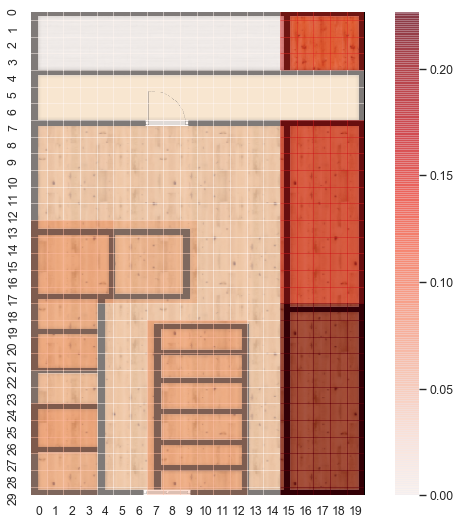

In [67]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')

map_img = mpimg.imread('Level3FP.png') 
hmax = sns.heatmap(heatmap_data,
            cmap = cm.Reds,
            alpha = 0.5, # whole heatmap is translucent
            annot = False,
            zorder = 2,
            square = True
            )

# heatmap uses pcolormesh instead of imshow, so we can't pass through 
# extent as a kwarg, so we can't mmatch the heatmap to the map. Instead, 
# match the map to the heatmap:

hmax.imshow(map_img,
          aspect = hmax.get_aspect(),
          extent = hmax.get_xlim() + hmax.get_ylim(),
          zorder = 1) #put the map under the heatmap
show()

In [68]:
# initializing heatmap with zeros
heatmap_data = np.zeros(600).reshape((30,20))

# populating heatmap with density

# e.g. for x - 1,2,3 y - 6 to 10 
heatmap_data[np.ix_([i for i in range(27,30)],[0,1,2,3])] = density_df['Density'][density_df['Facility'] == ('SMUC Study Booth 4-1')]
heatmap_data[np.ix_([i for i in range(24,27)],[0,1,2,3])] = density_df['Density'][density_df['Facility'] == ('SMUC Study Booth 4-2')]
heatmap_data[np.ix_([i for i in range(22,24)],[0,1,2,3])] = density_df['Density'][density_df['Facility'] == ('SMUC Study Booth 4-3')]
heatmap_data[np.ix_([i for i in range(20,22)],[0,1,2,3])] = density_df['Density'][density_df['Facility'] == ('SMUC Study Booth 4-4')]
heatmap_data[np.ix_([i for i in range(18,20)],[0,1,2,3])] = density_df['Density'][density_df['Facility'] == ('SMUC Study Booth 4-5')]
heatmap_data[np.ix_([i for i in range(16,18)],[0,1,2,3])] = density_df['Density'][density_df['Facility'] == ('SMUC Study Booth 4-6')]
heatmap_data[np.ix_([i for i in range(13,16)],[0,1,2,3])] = density_df['Density'][density_df['Facility'] == ('SMUC Study Booth 4-7')]
heatmap_data[np.ix_([i for i in range(11,13)],[0,1,2,3])] = density_df['Density'][density_df['Facility'] == ('SMUC Study Booth 4-8')]
heatmap_data[np.ix_([i for i in range(9,11)],[0,1,2,3])] = density_df['Density'][density_df['Facility'] == ('SMUC Study Booth 4-9')]
heatmap_data[np.ix_([i for i in range(7,9)],[0,1,2,3])] = density_df['Density'][density_df['Facility'] == ('SMUC Study Booth 4-10')]

heatmap_data[np.ix_([i for i in range(4,7)],[0,1,2,3])] = density_df['Density'][density_df['Facility'] == ('SMUC Meeting Lounge 4-1 ')]

heatmap_data[np.ix_([i for i in range(18,30)],[i for i in range(15,20)])] = density_df['Density'][density_df['Facility'].str.contains('SMUC Active Learning Classroom 4-1')]
heatmap_data[np.ix_([i for i in range(7,18)],[i for i in range(15,20)])] = density_df['Density'][density_df['Facility'].str.contains('SMUC Active Learning Classroom 4-2')]

heatmap_data[np.ix_([i for i in range(0,4)],[i for i in range(15,20)])] = density_df['Density'][density_df['Facility'].str.contains('SMUC Jamming Room')]


heatmap_data[np.ix_([i for i in range(22,27)],[5,6,7])] = density_df['Density'][density_df['Facility'] == ('SMUC Meeting Pod 4-5')]
heatmap_data[np.ix_([i for i in range(22,27)],[8,9])] = density_df['Density'][density_df['Facility'] == ('SMUC Meeting Pod 4-6')]
heatmap_data[np.ix_([i for i in range(22,27)],[10,11])] = density_df['Density'][density_df['Facility'] == ('SMUC Meeting Pod 4-7')]

heatmap_data[np.ix_([i for i in range(11,16)],[5,6,7])] = density_df['Density'][density_df['Facility'] == ('SMUC Meeting Pod 4-4')]
heatmap_data[np.ix_([i for i in range(11,16)],[8,9])] = density_df['Density'][density_df['Facility'] == ('SMUC Meeting Pod 4-3')]
heatmap_data[np.ix_([i for i in range(11,16)],[10,11])] = density_df['Density'][density_df['Facility'] == ('SMUC Meeting Pod 4-2')]
heatmap_data[np.ix_([i for i in range(11,16)],[12,13])] = density_df['Density'][density_df['Facility'] == ('SMUC Meeting Pod 4-1')]


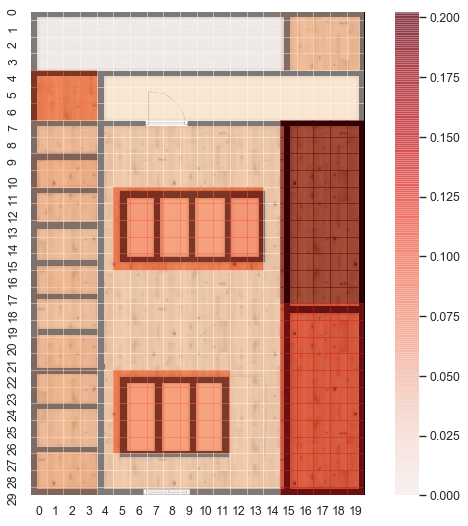

In [69]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')

map_img = mpimg.imread('Level4FP.png') 
hmax = sns.heatmap(heatmap_data,
            cmap = cm.Reds,
            alpha = 0.5, # whole heatmap is translucent
            annot = False,
            zorder = 2,
            square = True
            )

# heatmap uses pcolormesh instead of imshow, so we can't pass through 
# extent as a kwarg, so we can't mmatch the heatmap to the map. Instead, 
# match the map to the heatmap:

hmax.imshow(map_img,
          aspect = hmax.get_aspect(),
          extent = hmax.get_xlim() + hmax.get_ylim(),
          zorder = 1) #put the map under the heatmap
show()

In [77]:
# initializing heatmap with zeros
heatmap_data = np.zeros(600).reshape((30,20))

# populating heatmap with density
# e.g. for x - 1,2,3 y - 6 to 10 

heatmap_data[np.ix_([i for i in range(22,30)],[i for i in range(15,20)])] = density_df['Density'][density_df['Facility'].str.contains('SMUC Integrated Learning Studio')]
heatmap_data[np.ix_([i for i in range(23,30)],[i for i in range(0,8)])] = density_df['Density'][density_df['Facility'].str.contains('SMUC Study Booth 2-1')]
heatmap_data[np.ix_([i for i in range(2,10)],[i for i in range(0,8)])] = density_df['Density'][density_df['Facility'].str.contains('SMUC Study Booth 2-2')]


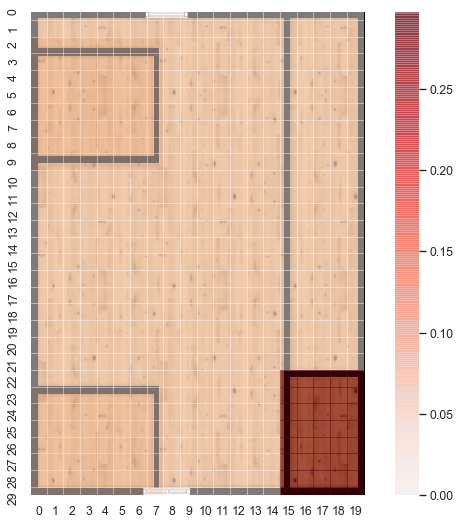

In [80]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')

map_img = mpimg.imread('Level2FP.png') 
hmax = sns.heatmap(heatmap_data,
            cmap = cm.Reds,
            alpha = 0.5, # whole heatmap is translucent
            annot = False,
            zorder = 2,
            square = True
            )

# heatmap uses pcolormesh instead of imshow, so we can't pass through 
# extent as a kwarg, so we can't mmatch the heatmap to the map. Instead, 
# match the map to the heatmap:

hmax.imshow(map_img,
          aspect = hmax.get_aspect(),
          extent = hmax.get_xlim() + hmax.get_ylim(),
          zorder = 1) #put the map under the heatmap
show()

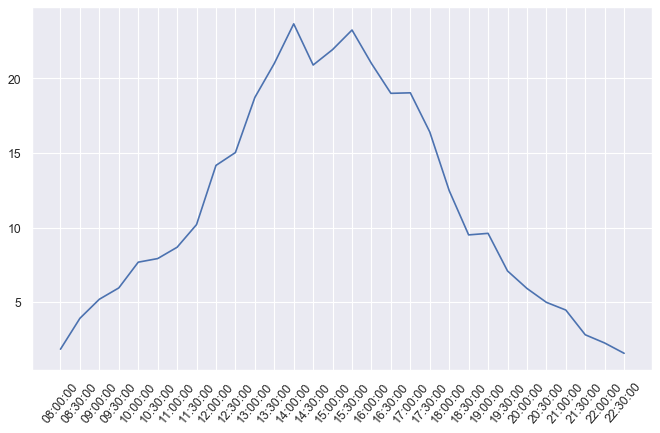

In [16]:
#Average occupancy of all facilities over the course of the day (averaged across the month)
timestamps = pd.date_range("08:00", "22:30", freq="30min")
avg_occupancy_list = [df[(df['Booking Start'].dt.time <= time.time()) & (df['Booking End'].dt.time >= time.time())].shape[0]/29 for time in timestamps]


from matplotlib.pyplot import figure
figure(num=None, figsize=(10, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(timestamps.strftime('%H:%M:%S'),avg_occupancy_list)
a = plt.xticks(rotation=50)

In [17]:

df[df['Booking Date']=='08/02/2020']

,Booking Time,Booking Status,Booking Reference Number,Booked for User Name,Booked for User Org Unit,Booked for User Email Address,Use Type,Purpose of Booking,Booking Date,Facility,Booking Start,Booking End,Hours Booked
378,08:30-17:00,Confirmed,BK-20200130-000970,KYAW Thura,Facilities Management & Services,KYAWTHURA@SMU.EDU.SG,Maintenance,Maintenance,08/02/2020,SMUC Active Learning Classroom 3-1,2020-08-02 08:30:00,2020-08-02 17:00:00,08:30:00
379,08:30-08:45,Confirmed,BK-20200130-000971,KYAW Thura,Facilities Management & Services,KYAWTHURA@SMU.EDU.SG,Maintenance,Maintenance,08/02/2020,SMUC Active Learning Classroom 3-2,2020-08-02 08:30:00,2020-08-02 08:45:00,00:15:00
380,09:00-12:00,Confirmed,BK-20200128-001251,Moot Court Club,,smulawmoots@sa.smu.edu.sg,Co-Curricular,LRW Prac Rounds,08/02/2020,SMUC Active Learning Classroom 3-2,2020-08-02 09:00:00,2020-08-02 12:00:00,03:00:00
381,12:00-17:00,Confirmed,BK-20200130-000972,KYAW Thura,Facilities Management & Services,KYAWTHURA@SMU.EDU.SG,Maintenance,Maintenance,08/02/2020,SMUC Active Learning Classroom 3-2,2020-08-02 12:00:00,2020-08-02 17:00:00,05:00:00
382,08:30-17:00,Confirmed,BK-20200130-000973,KYAW Thura,Facilities Management & Services,KYAWTHURA@SMU.EDU.SG,Maintenance,Maintenance,08/02/2020,SMUC Active Learning Classroom 3-3,2020-08-02 08:30:00,2020-08-02 17:00:00,08:30:00
383,08:30-17:00,Confirmed,BK-20200130-000974,KYAW Thura,Facilities Management & Services,KYAWTHURA@SMU.EDU.SG,Maintenance,Maintenance,08/02/2020,SMUC Active Learning Classroom 4-1,2020-08-02 08:30:00,2020-08-02 17:00:00,08:30:00
384,08:30-17:00,Confirmed,BK-20200130-000975,KYAW Thura,Facilities Management & Services,KYAWTHURA@SMU.EDU.SG,Maintenance,Maintenance,08/02/2020,SMUC Active Learning Classroom 4-2,2020-08-02 08:30:00,2020-08-02 17:00:00,08:30:00
385,08:30-17:00,Confirmed,BK-20200130-000976,KYAW Thura,Facilities Management & Services,KYAWTHURA@SMU.EDU.SG,Maintenance,Maintenance,08/02/2020,SMUC Chatterbox 3-1,2020-08-02 08:30:00,2020-08-02 17:00:00,08:30:00
386,08:30-17:00,Confirmed,BK-20200130-000977,KYAW Thura,Facilities Management & Services,KYAWTHURA@SMU.EDU.SG,Maintenance,Maintenance,08/02/2020,SMUC Chatterbox 3-2,2020-08-02 08:30:00,2020-08-02 17:00:00,08:30:00
387,08:30-17:00,Confirmed,BK-20200130-000978,KYAW Thura,Facilities Management & Services,KYAWTHURA@SMU.EDU.SG,Maintenance,Maintenance,08/02/2020,SMUC Chatterbox 3-3,2020-08-02 08:30:00,2020-08-02 17:00:00,08:30:00


C:\Users\Junrong\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


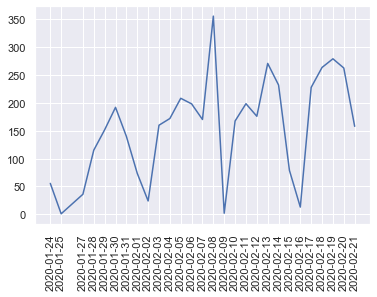

In [18]:
# number of hours by day - we can observe how the booking hours increases over the weeks. And weekends have a sharp drop.
daily_df = df.groupby('Booking Date').agg({'Hours Booked' :'sum'}).reset_index()
daily_df['Booking Date'] = pd.to_datetime(daily_df['Booking Date'],dayfirst=True)
daily_df = daily_df.sort_values(by='Booking Date')

plt.plot(daily_df['Booking Date'],daily_df['Hours Booked']/np.timedelta64(1, 'h'))
a = plt.xticks(daily_df['Booking Date'],rotation= 90)

In [ ]:
df['Day of week'] = pd.to_datetime(df['Booking Date'], dayfirst=True).dt.day_name()

# aggregated by day
daily_df = df.groupby(['Day of week']).agg({'Hours Booked' :'sum'}).reset_index()
daily_df['Day of week2'] = daily_df['Day of week'].replace(mydict)
daily_df = daily_df.sort_values(by='Day of week2')


plt.plot(daily_df['Day of week2'],daily_df['Hours Booked']/np.timedelta64(1, 'h'))
a = plt.xticks(daily_df['Day of week2'],rotation= 90)

In [ ]:
# usage by category (learning space, study corner gsr) - which type of facility is underutilized
facility_df = df.groupby("Facility Type").agg({'Hours Booked' :'sum'}).reset_index().sort_values(by='Hours Booked',ascending=False)
plt.bar(facility_df['Facility Type'], facility_df['Hours Booked']/np.timedelta64(1, 'h'))
a = plt.xticks(facility_df['Facility Type'],rotation=90)